# MOM-SIS 0.1$^\circ$ Diagnostics

This notebook calculates and retains key diagnostics from our mom01v5 simulations. The following experiments are included:

| Experiment Name | Description |
|-----------------|-----------------|
|GFDL50 | Original simulation with 50 vertical levels. Ran from Levitus for about 60 years, but data output only saved from about year 40.|
|KDS75 | Branched from GFDL50 at year 45 (re-zeroed), but with Kial Stewart's 75 level scheme. Has now run for 103 years. Years 90-100 have 5-daily output.|
| KDS75_wind | Short (5-year) Antarctic wind perturbation case, branched from KDS75 at year 40.|
| KDS75_PI | Paul Spence's Poleward Intensification wind experiment. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade|
| KDS75_UP | Paul Spence's Increased winds case. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade. (In Progress) |

**Last updated March 30 2017.**

https://github.com/jmunroe/cosima.git

In [1]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'

### Experiments

In [2]:
expts = ['GFDL50','KDS75','KDS75_PI','KDS75_wind']

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

In [4]:
pbar = ProgressBar()
pbar.register()

In [5]:
# set up dask to initiate 4 parallel processors.
dask.set_options(get=dask.multiprocessing.get, num_workers=4)

## Wind Stress fields
The following code block shows the zonal- and time-averaged wind stress forcing for each experiment.

GFDL50 - Already Processed
KDS75 - Already Processed
KDS75_PI - Already Processed
KDS75_wind - Already Processed


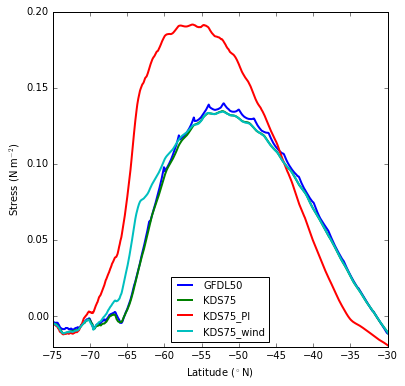

In [6]:
plt.figure(figsize=(6,6))
for e in expts:
    ExpDir = os.path.join(DataDir,e)

    # Is there any processed data to load?
    AvgeWindFile = os.path.join(ExpDir,'TauX_Last5Years.nc')
    if os.path.exists(AvgeWindFile):
        print (e + ' - Already Processed')
    else: 
        # average last 20 outputs (~ 5 years)
        FileList = [f for f in os.listdir(ExpDir) if f.startswith('output')]
        FileList.sort()
        FileString = ''
        for f in FileList[-20:]:
            FileString  = FileString + ' ' + ExpDir + '/' + f + '/ocean_month.nc' 

        NCRA_COMMAND = "ncra " + FileString + ' -v tau_x ' + AvgeWindFile
        print (NCRA_COMMAND)
        print (" ")
        result = os.system(NCRA_COMMAND)
        if result != 0:
            print ("\nERROR code for NCRA: %s" % (result))

    nc = Dataset(AvgeWindFile)
    tau = nc.variables['tau_x'][:,:,:]
    lat = nc.variables['yu_ocean'][:]
    nc.close()

    tau_bar = np.ma.mean(tau,axis=2)[0,:]
    plt.plot(lat,tau_bar,linewidth=2,label=e)

plt.xlim([-75,-30])
plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8,fontsize=10)
plt.savefig('figures/WindStress.pdf')

# Major Transports
In this section, we catalogue and save transport diagnostics from each of the major straits.

Still to think about:
* Should we show a map of strait definitions first up?
* Should we put the background functions into a separate python file and load as a module?
* What other straits should we choose? Bering? Med? Denmark St? FBC?


In [53]:
## This code block contains functions which we may move to an external module someday ...

## Function to calculate barotropic transport across a given line of latitude or longitude.
## Primarily designed for flow through straits.
def calculate_transport(OceanFile,TransDict):
    try:
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        if 'xloc' in TransDict:
            tx_trans = dsx.tx_trans[0,:,TransDict['ymin']:TransDict['ymax'],TransDict['xloc']]
            transport = tx_trans.sum()
            valrange = tx_trans.valid_range[1]
        elif 'yloc' in TransDict:
            ty_trans = dsx.ty_trans[0,:,TransDict['yloc'],TransDict['xmin']:TransDict['xmax']]
            transport = ty_trans.sum()
            valrange = ty_trans.valid_range[1]
        else:
            transport = np.nan

        if np.isnan(transport.values):
            transport = np.nan
        elif transport.values > valrange:
            transport = np.nan
                
    except:
        transport = np.nan
    
    return OceanFile, transport

## This function calculates a 4-point running mean.
## Designed to be an annual mean for quarterly data output
def annual_average(timeseries):
    nt = timeseries.size
    avged_timeseries = timeseries.copy()
    for ii in range(nt):
        avged_timeseries[ii] = timeseries[np.max([0,ii-2]):np.min([ii+2,nt])].mean()
    
    # Correct ends
    avged_timeseries[0] = timeseries[:4].mean()
    avged_timeseries[1] = timeseries[:4].mean()
    avged_timeseries[-1] = timeseries[-4:].mean()
        
    return avged_timeseries

In [8]:
DrakeDict = {'xloc':2100,'ymin':225,'ymax':650}
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'DrakePassageTransport.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn,DrakeDict) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))

[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [9]:
LombokDict = {'yloc':1158,'xmin':354,'xmax':361}
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'LombokTransport.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn,LombokDict) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))

[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [10]:
OmbaiDict = {'xloc':449,'ymin':1152,'ymax':1163}
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'OmbaiTransport.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn,OmbaiDict) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [31]:
TimorDict = {'xloc':440,'ymin':1125,'ymax':1145}
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'TimorTransport.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn,TimorDict) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))


[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  1.3s


In [12]:
BeringDict = {'yloc':2125,'xmin':1080,'xmax':1130}

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'BeringTransport.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn,BeringDict) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))


[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed | 39.2s
[########################################] | 100% Completed | 14.1s
[########################################] | 100% Completed |  3.1s


In [15]:
DenmarkDict = {'yloc':2125,'xmin':2380,'xmax':2580}

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'DenmarkTransport.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn,DenmarkDict) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=8) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))




[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 19.1s
[########################################] | 100% Completed |  4.1s


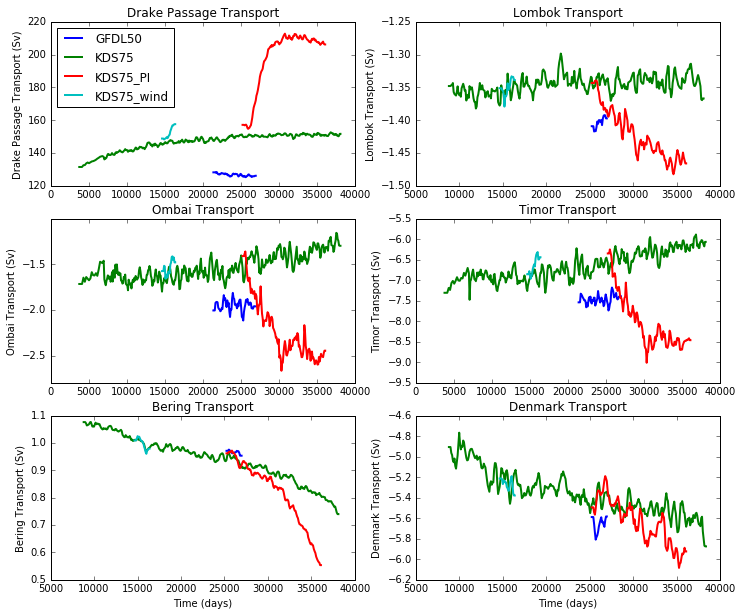

In [54]:
plt.figure(figsize=(12,10))
MetricsFiles = ['DrakePassageTransport.pkl','LombokTransport.pkl','OmbaiTransport.pkl',
                'TimorTransport.pkl', 'BeringTransport.pkl', 'DenmarkTransport.pkl']

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    nplot = 0
    for MetricsFile in MetricsFiles:
        nplot += 1
        transports = pickle.load(open(MetricsFile, 'rb'))
        transport = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')
        plt.subplot(3,2,nplot)
        annual_average(transport).plot(label=expt,linewidth=2)
        plt.title(MetricsFile)

plt.subplot(321)
plt.legend(loc='upper left')
plt.ylabel('Transport (Sv)')
plt.xlabel('')

plt.subplot(322)
MetricsFile = 'LombokTransport.pkl'
transports = pickle.load(open(MetricsFile, 'rb'))

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    transport = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')
    annual_average(transport).plot(linewidth=2)

#plt.legend(loc='lower right')
plt.ylabel('Lombok Transport (Sv)')
plt.xlabel('')
plt.title('Lombok Transport')


plt.subplot(323)
MetricsFile = 'OmbaiTransport.pkl'
transports = pickle.load(open(MetricsFile, 'rb'))

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    transport = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')
    annual_average(transport).plot(linewidth=2)


#plt.legend(loc='lower right')
plt.ylabel('Ombai Transport (Sv)')
plt.xlabel('')
plt.title('Ombai Transport')


plt.subplot(324)
MetricsFile = 'TimorTransport.pkl'
transports = pickle.load(open(MetricsFile, 'rb'))

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    transport = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')
    annual_average(transport).plot(linewidth=2)
    
#plt.legend(loc='upper left')
plt.ylabel('Timor Transport (Sv)')
plt.xlabel('')
plt.title('Timor Transport')

plt.subplot(325)
MetricsFile = 'BeringTransport.pkl'
transports = pickle.load(open(MetricsFile, 'rb'))

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    transport = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')
    annual_average(transport).plot(linewidth=2)
    
#plt.legend(loc='upper left')
plt.ylabel('Bering Transport (Sv)')
plt.xlabel('Time (days)')
plt.title('Bering Transport')


plt.subplot(326)
MetricsFile = 'DenmarkTransport.pkl'
transports = pickle.load(open(MetricsFile, 'rb'))

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    transport = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')
    annual_average(transport).plot(linewidth=2)
    
#plt.legend(loc='upper left')
plt.ylabel('Denmark Transport (Sv)')
plt.xlabel('Time (days)')
plt.title('Denmark Transport')

plt.savefig('figures/Transports.pdf')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

In [40]:
def extract_data(f):
    dataset = Dataset(f)
    
    data = {}
    for v in dataset.variables.values():
        if 'time' in v.dimensions and 'scalar_axis' in v.dimensions:
            data[v.name] = v[:].flatten()
    index = pd.to_datetime(dataset['time'][:], unit='D')
    df = pd.DataFrame(index=index, data=data)
    return df

scalar_quantities = {}

for expt in expts:
    expdir = os.path.join(DataDir,expt)
    DataFileList = glob(os.path.join(expdir, 'output*/ocean_scalar.nc'))

    frames = [ delayed(extract_data)(f) for f in DataFileList]
    if len(frames) > 0:
        scalar_quantities[expt] = delayed(pd.concat)(frames).compute(num_workers=4)

[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  0.7s


In [41]:
scalar_quantities['KDS75'].describe().T

,count,mean,std,min,25%,50%,75%,max
eta_global,1133.0,-1.597870e-02,6.129906e-03,-2.518725e-02,-2.221310e-02,-1.538444e-02,-9.511603e-03,-7.689955e-03
ke_tot,1133.0,3.207048e+03,4.291650e+01,3.069407e+03,3.177896e+03,3.207977e+03,3.235973e+03,3.337936e+03
pe_tot,1133.0,2.923421e+10,2.173724e+05,2.923390e+10,2.923395e+10,2.923397e+10,2.923408e+10,2.923417e+10
rhoave,1133.0,1.037503e+03,8.566287e-03,1.037507e+03,1.037511e+03,1.037512e+03,1.037513e+03,1.037514e+03
salt_global_ave,1133.0,3.471843e+01,3.027011e-04,3.471807e+01,3.471810e+01,3.471812e+01,3.471817e+01,3.471822e+01
salt_surface_ave,1133.0,3.457333e+01,4.109482e-02,3.446720e+01,3.454594e+01,3.457895e+01,3.460441e+01,3.464874e+01
temp_global_ave,1133.0,3.586190e+00,8.013928e-03,3.571681e+00,3.580265e+00,3.585006e+00,3.591141e+00,3.609689e+00
temp_surface_ave,1133.0,1.818346e+01,1.870494e-01,1.782814e+01,1.811521e+01,1.820282e+01,1.831704e+01,1.849554e+01
total_net_sfc_heating,1133.0,6.722477e-02,4.472941e+00,-7.733866e+00,-4.983775e+00,1.707373e+00,3.878277e+00,5.793462e+00
total_ocean_calving,1133.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


CPU times: user 865 ms, sys: 1.06 s, total: 1.93 s
Wall time: 872 ms


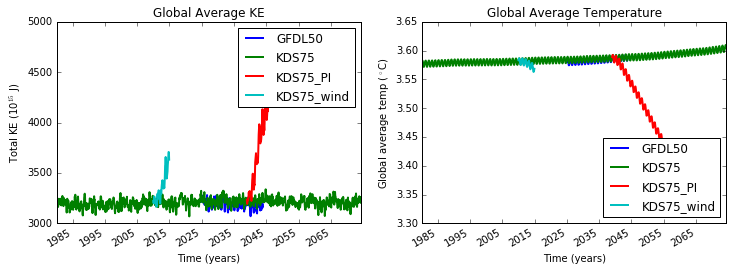

In [42]:
%%time

plt.figure(figsize=(12,4))

for expt in expts:
    plt.subplot(121)
    scalar_quantities[expt].ke_tot.plot(label=expt, linewidth=2)

    plt.subplot(122)
    scalar_quantities[expt].temp_global_ave.plot(label=expt, linewidth=2)

plt.subplot(121)
plt.legend(loc='upper right')
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc='lower right')
plt.ylabel('Global average temp ($^\circ$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')

plt.savefig('figures/Scalars.pdf')

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [7]:
def calculate_Ψ(expt, count = 4):
    ExpDir = os.path.join(DataDir, expt)

    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()

    Ψ = 0
    for OceanFile in FileList[-count:]: 

        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4', chunks={'potrho':5})
        
        psi_partial = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
        dsx.close()

        Ψ = Ψ + psi_partial

    Ψ_avg = Ψ/count

    return Ψ_avg


In [8]:
def plot_psi(psi, expt, clev=np.arange(-20,20,2)):
    #x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

    plt.contourf(psi.grid_yu_ocean, psi.potrho, psi, cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

In [9]:
%%time
psi_KDS = calculate_Ψ('KDS75', count=10)
psi_GFDL = calculate_Ψ('GFDL50', count=10)
psi_KDS_PI = calculate_Ψ('KDS75_PI', count=10)

KeyboardInterrupt: 

In [74]:
%%time 
psi_KDS.load()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 214 µs


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   3.689503e-05,
         -2.192812e-04,  -4.137445e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -4.082480e-06,
         -3.397561e-04,  -5.152062e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -8.780851e-06,
         -3.518526e-04,  -5.517177e-04],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   6.579528e-04,
          2.837390e-04,  -6.001448e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   6.579528e-04,
          2.837390e-04,  -6.001448e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   6.579528e-04,
          2.837390e-04,  -6.001448e-05]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

In [ ]:
psi_GFDL.load()

In [ ]:
psi_diff = psi_KDS - psi_GFDL

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(311)
plot_psi(psi_KDS, 'KDS75')

plt.subplot(312)
plot_psi(psi_GFDL, 'GFDL50')

plt.subplot(313)
plot_psi(psi_diff, 'KDS75 - GFDL50', clev = np.arange(-5,5,0.5))

In [ ]:
print ('For densities exceeding: ', psi_KDS.potrho[68].values)
print ('And at latitude:', psi_KDS.grid_yu_ocean[500].values)
print ('GFDL50 Min', np.min(psi_GFDL[68:,500]).values)
print ('KDS75 Min', np.min(psi_KDS[68:,500]).values)

In [75]:
%%time 
psi_KDS_PI.load()
psi_diff = psi_KDS_PI - psi_KDS

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.08 ms


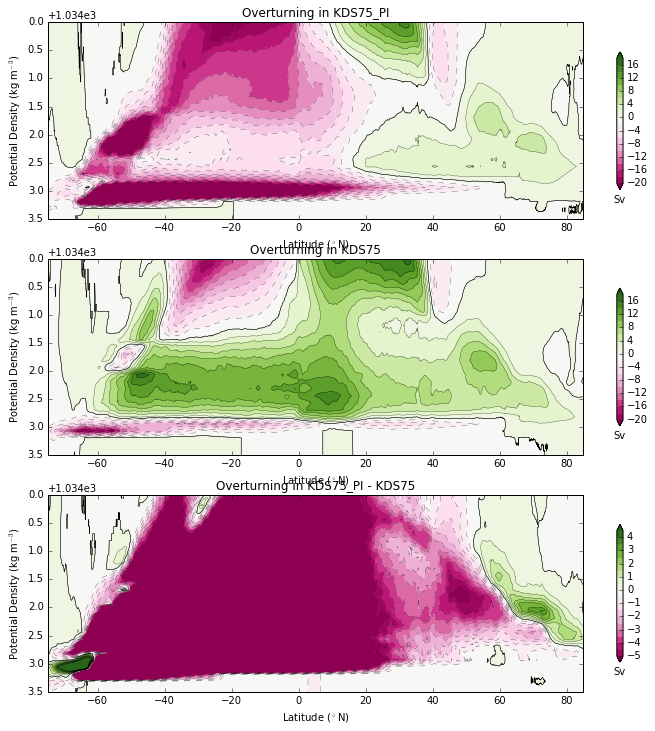

In [76]:
plt.figure(figsize=(12,12))

plt.subplot(311)
plot_psi(psi_KDS_PI, 'KDS75_PI')

plt.subplot(312)
plot_psi(psi_KDS,'KDS75')

plt.subplot(313)
plot_psi(psi_diff, 'KDS75_PI - KDS75', clev = np.arange(-5,5,0.5))

# Indo Throughflow??
* Still a work in progress ....

<xarray.DataArray 'ty_trans' ()>
array(-1.473966432557063)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 -8.568


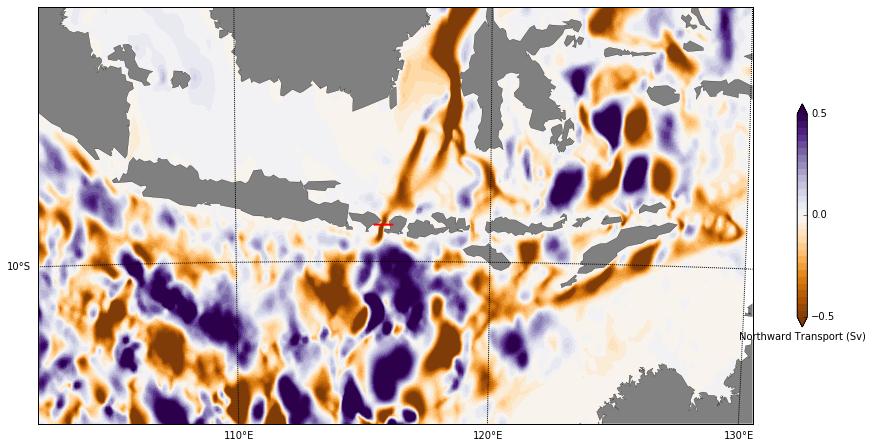

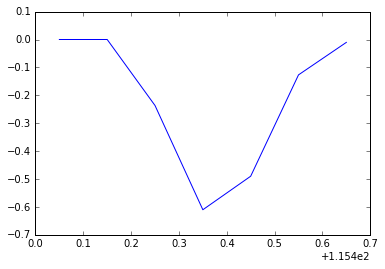

In [51]:
## test code to play with computation of lombok transport

# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,:1500,:500]
x = dsx.xt_ocean[:500]
y = dsx.yu_ocean[:1500]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-16,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
LombokDict = {'yloc':1158,'xmin':354,'xmax':361}
xx = np.array([X[LombokDict['yloc'],LombokDict['xmin']], X[LombokDict['yloc'],LombokDict['xmax']]])+360
yy = np.array([Y[LombokDict['yloc'],LombokDict['xmin']],Y[LombokDict['yloc'],LombokDict['xmax']]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')


plt.figure()
plt.plot(x[354:361]+360,transport[LombokDict['yloc'],LombokDict['xmin']:LombokDict['xmax']])
lombok_transport = np.sum(transport[LombokDict['yloc'],LombokDict['xmin']:LombokDict['xmax']])

print(lombok_transport)

<xarray.DataArray 'tx_trans' ()>
array(-1.2015297539478524)
Coordinates:
    time      float64 3.609e+04
    xu_ocean  float64 -235.0
<xarray.DataArray 'tx_trans' ()>
array(-4.769188458296412)
Coordinates:
    time      float64 3.609e+04
    xu_ocean  float64 -235.9


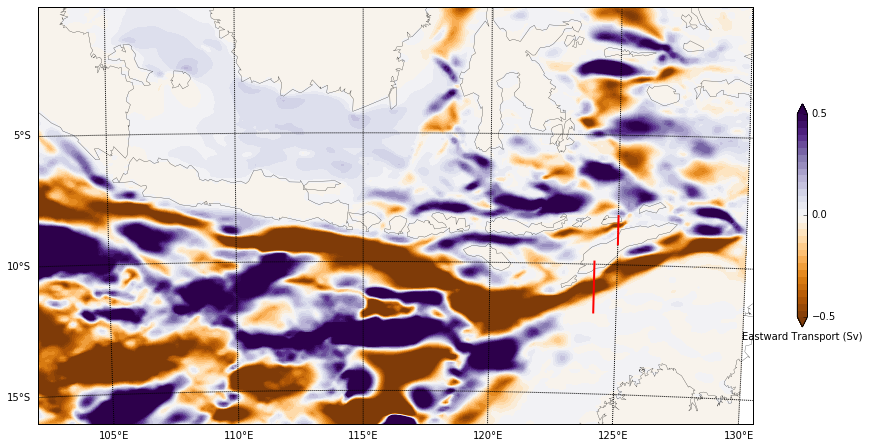

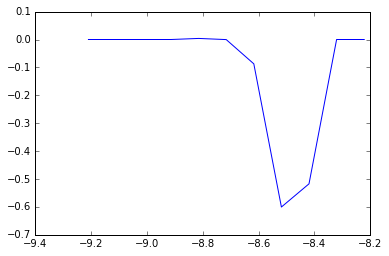

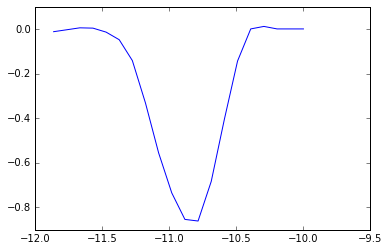

In [26]:
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output385/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
tx_trans = dsx.tx_trans[0,:,:1500,:500]
x = dsx.xu_ocean[:500]
y = dsx.yt_ocean[:1500]
transport = tx_trans.sum(axis=0)
xv, yv = np.meshgrid(x, y)

plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-16,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
#map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Eastward Transport (Sv)')


# pick exact location and sum for each strait
# This for Ombai
OmbaiDict = {'xloc':449,'ymin':1152,'ymax':1163}
xx = np.array([X[OmbaiDict['ymin'],OmbaiDict['xloc']], X[OmbaiDict['ymax'],OmbaiDict['xloc']]])+360
yy = np.array([Y[OmbaiDict['ymin'],OmbaiDict['xloc']],Y[OmbaiDict['ymax'],OmbaiDict['xloc']]])
map.plot(xx,yy,linewidth=2,color='r')

# This for Timor
TimorDict = {'xloc':440,'ymin':1125,'ymax':1145}
xx = np.array([X[TimorDict['ymin'],TimorDict['xloc']], X[TimorDict['ymax'],TimorDict['xloc']]])+360
yy = np.array([Y[TimorDict['ymin'],TimorDict['xloc']],Y[TimorDict['ymax'],TimorDict['xloc']]])
map.plot(xx,yy,linewidth=2,color='r')

# plot and measure ombai
plt.figure()
plt.plot(y[OmbaiDict['ymin']:OmbaiDict['ymax']],transport[OmbaiDict['ymin']:OmbaiDict['ymax'],OmbaiDict['xloc']])
ombai_transport = np.sum(transport[OmbaiDict['ymin']:OmbaiDict['ymax'],OmbaiDict['xloc']])
print(ombai_transport)

# plot and measure timor
plt.figure()
plt.plot(y[TimorDict['ymin']:TimorDict['ymax']],transport[TimorDict['ymin']:TimorDict['ymax'],TimorDict['xloc']])
timor_transport = np.sum(transport[TimorDict['ymin']:TimorDict['ymax'],TimorDict['xloc']])
print(timor_transport)


<xarray.DataArray 'ty_trans' ()>
array(1.0250125366146676)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 65.75


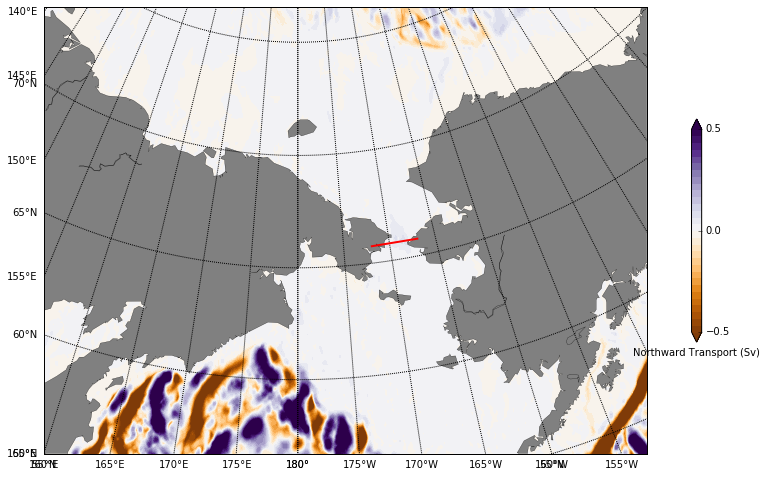

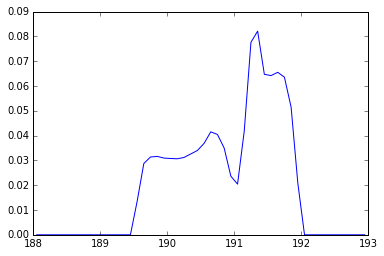

In [59]:
# Bering Strait
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,:,:1500]
x = dsx.xt_ocean[:1500]
y = dsx.yu_ocean[:]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-200,llcrnrlat=55,urcrnrlon=-130,urcrnrlat=70,projection='stere',resolution='l',lon_0=-180,lat_0=60)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
BeringDict = {'yloc':2125,'xmin':1080,'xmax':1130}
xx = np.array([X[BeringDict['yloc'],BeringDict['xmin']], X[BeringDict['yloc'],BeringDict['xmax']]])+360
yy = np.array([Y[BeringDict['yloc'],BeringDict['xmin']],Y[BeringDict['yloc'],BeringDict['xmax']]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

plt.figure()
plt.plot(x[BeringDict['xmin']:BeringDict['xmax']]+360,transport[BeringDict['yloc'],BeringDict['xmin']:BeringDict['xmax']])
bering_transport = np.sum(transport[BeringDict['yloc'],BeringDict['xmin']:BeringDict['xmax']])

print(bering_transport)

<xarray.DataArray 'ty_trans' ()>
array(-4.258176312495108)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 65.75


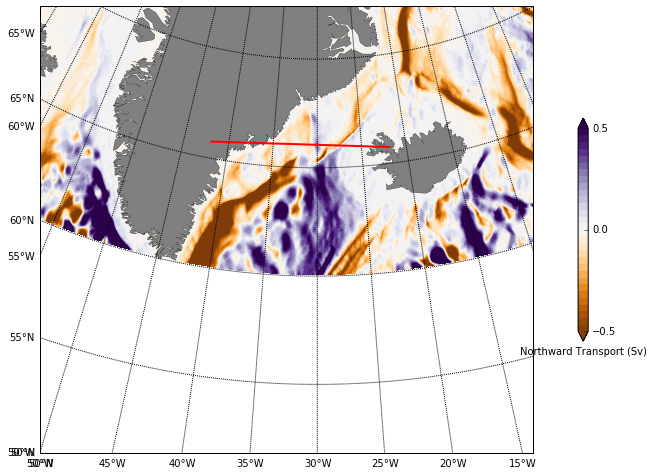

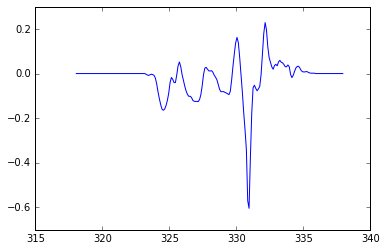

In [15]:
# Denmark Strait
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,2000:,2000:3000]
x = dsx.xt_ocean[2000:3000]
y = dsx.yu_ocean[2000:]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Iceland
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-50,llcrnrlat=50,urcrnrlon=0,urcrnrlat=70,projection='stere',resolution='l',lon_0=-30,lat_0=60)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
DenmarkDict = {'yloc':2125,'xmin':2380,'xmax':2580}
xx = np.array([X[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000], X[DenmarkDict['yloc']-2000,DenmarkDict['xmax']-2000]])+360
yy = np.array([Y[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000],Y[DenmarkDict['yloc']-2000,DenmarkDict['xmax']-2000]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

plt.figure()
plt.plot(x[DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000]+360,transport[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000])
denmark_transport = np.sum(transport[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000])

print(denmark_transport)